In [1]:
import requests
from pymongo import MongoClient
from xml.etree import ElementTree

# Function to convert an XML element and its children to a dictionary
def xml_to_dict(element):
    return {child.tag: child.text for child in element}

# Download the dataset
url = "https://data.cdc.gov/api/views/xt86-xqxz/rows.xml?accessType=DOWNLOAD"
response = requests.get(url)
dataset_xml = response.content

# Parse the XML
root = ElementTree.fromstring(dataset_xml)

# Connect to MongoDB
client = MongoClient('localhost', 27017)
db = client['cdc_data']
collection = db['dataset']

# Iterate over each 'row' element and store it in MongoDB
for row in root.findall('.//row'):  # Direct path to 'row' elements
    record = xml_to_dict(row)
    collection.insert_one(record)


In [2]:
import psycopg2

def create_table():
    # Connect to your PostgreSQL database
    conn = psycopg2.connect(
        dbname="postgres", 
        user="postgres", 
        password="admin", 
        host="localhost"
    )
    cur = conn.cursor()

    # SQL command to create the table
    create_table_command = """
    CREATE TABLE IF NOT EXISTS healthcare_visits (
        id SERIAL PRIMARY KEY,
        indicator TEXT,
        panel TEXT,
        panel_num INTEGER,
        unit TEXT,
        unit_num INTEGER,
        stub_name TEXT,
        stub_name_num INTEGER,
        stub_label TEXT,
        stub_label_num NUMERIC,
        year INTEGER,
        year_num INTEGER,
        age TEXT,
        age_num NUMERIC,
        estimate BIGINT
    );
    """

    # Execute the command and commit the changes
    cur.execute(create_table_command)
    conn.commit()

    # Close the cursor and connection
    cur.close()
    conn.close()

# Call the function to create the table
create_table()

In [3]:
import luigi
import json
from pymongo import MongoClient
import psycopg2

class ExtractFromMongoDB(luigi.Task):
    def run(self):
        client = MongoClient('localhost', 27017)
        db = client['cdc_data']
        collection = db['dataset']
        data = collection.find({})
        with self.output().open('w') as out_file:
            for record in data:
                # Use json.dumps to ensure the record is converted to a valid JSON string
                json_record = json.dumps(record, default=str)
                out_file.write(json_record + '\n')

    def output(self):
        return luigi.LocalTarget('data_from_mongo.txt')

class TransformData(luigi.Task):
    def requires(self):
        return ExtractFromMongoDB()

    def run(self):
        with self.input().open() as in_file, self.output().open('w') as out_file:
            for line in in_file:
                # Transform the data
                transformed_line = line  # Placeholder for transformation logic
                out_file.write(transformed_line)

    def output(self):
        return luigi.LocalTarget('transformed_data.txt')

class LoadToPostgreSQL(luigi.Task):
    def requires(self):
        return TransformData()

    def run(self):
        conn = psycopg2.connect("dbname='postgres' user='postgres' host='localhost' password='admin'")
        cur = conn.cursor()
        with self.input().open('r') as in_file:
            for line_num, line in enumerate(in_file, start=1):
                try:
                    record = json.loads(line.strip())
                except json.JSONDecodeError as e:
                    # Log the problematic line and its number
                    print(f"Error decoding JSON on line {line_num}: {line.strip()}")
                    print(f"Error message: {e}")
                    # Decide how you want to handle the error - skip, stop, etc.
                    raise  # Re-raise the exception if want the task to fail

        # close the database connections properly
        conn.commit()
        cur.close()
        conn.close()


    def output(self):
        return luigi.LocalTarget('load_complete.txt')

if __name__ == '__main__':
    luigi.run(['LoadToPostgreSQL', '--local-scheduler'])

DEBUG: Checking if LoadToPostgreSQL() is complete
DEBUG: Checking if TransformData() is complete
INFO: Informed scheduler that task   LoadToPostgreSQL__99914b932b   has status   PENDING
INFO: Informed scheduler that task   TransformData__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 14776] Worker Worker(salt=4186897308, workers=1, host=LAPTOP-8SM3OTCH, username=s43ag, pid=14776) running   LoadToPostgreSQL()
INFO: [pid 14776] Worker Worker(salt=4186897308, workers=1, host=LAPTOP-8SM3OTCH, username=s43ag, pid=14776) done      LoadToPostgreSQL()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   LoadToPostgreSQL__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=4186897308, workers=1, host=LAPTOP-8SM3OTCH, username=s43ag, pi

In [4]:
import psycopg2
from pymongo import MongoClient

# MongoDB connection
client = MongoClient('localhost', 27017)
db = client['cdc_data']
collection = db['dataset']

# Fetch all documents from the MongoDB collection
mongo_data = list(collection.find())

# PostgreSQL connection
conn = psycopg2.connect(dbname="postgres", user="postgres", password="admin", host="localhost")
cur = conn.cursor()

# Define the INSERT SQL query; adjust columns as per table schema
insert_query = '''
INSERT INTO healthcare_visits (indicator, panel, panel_num, unit, unit_num, stub_name, stub_name_num, stub_label, stub_label_num, year, year_num, age, age_num, estimate) 
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
'''

for record in mongo_data:
    data_tuple = (
        record.get('indicator'),
        record.get('panel'),
        record.get('panel_num'),
        record.get('unit'),
        record.get('unit_num'),
        record.get('stub_name'),
        record.get('stub_name_num'),
        record.get('stub_label'),
        record.get('stub_label_num'),
        record.get('year'),
        record.get('year_num'),
        record.get('age'),
        record.get('age_num'),
        record.get('estimate'),
    )
    
    # Execute the INSERT query
    try:
        cur.execute(insert_query, data_tuple)
    except Exception as e:
        print(f"Error inserting record: {e}")
        conn.rollback()  # Roll back the transaction on error
    else:
        conn.commit()  # Commit the transaction

# Close the cursor and connection to clean up
cur.close()
conn.close()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

# Establish connection to the PostgreSQL database
conn = psycopg2.connect(
    dbname="postgres", 
    user="postgres", 
    password="admin", 
    host="localhost"
)

# Modify the query to select all columns
query = "SELECT * FROM healthcare_visits ORDER BY year;"

# Load data into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Print the first few rows of the DataFrame to confirm all columns are fetched
print(df.head())

# Close the database connection
conn.close()

     id                                          indicator  \
0  6573  Visits to physician offices, hospital outpatie...   
1  7560  Visits to physician offices, hospital outpatie...   
2  6877  Visits to physician offices, hospital outpatie...   
3  8492  Visits to physician offices, hospital outpatie...   
4  5073  Visits to physician offices, hospital outpatie...   

                            panel  panel_num  \
0  Hospital emergency departments        4.0   
1                      All places        1.0   
2  Hospital emergency departments        4.0   
3               Physician offices        2.0   
4               Physician offices        2.0   

                                      unit  unit_num    stub_name  \
0  Number of visits per 100 persons, crude       3.0          Age   
1  Number of visits per 100 persons, crude       3.0  Sex and age   
2  Number of visits per 100 persons, crude       3.0         Race   
3  Number of visits per 100 persons, crude       3.0  Sex and 

c:\users\s43ag\appdata\local\programs\python\python38\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
# Convert columns to appropriate data types
df['year'] = pd.to_numeric(df['year'])
df['estimate'] = pd.to_numeric(df['estimate'])

C:\Users\s43ag\AppData\Local\Temp\ipykernel_14776\2089256609.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='year', y='estimate', estimator='sum', ci=None)


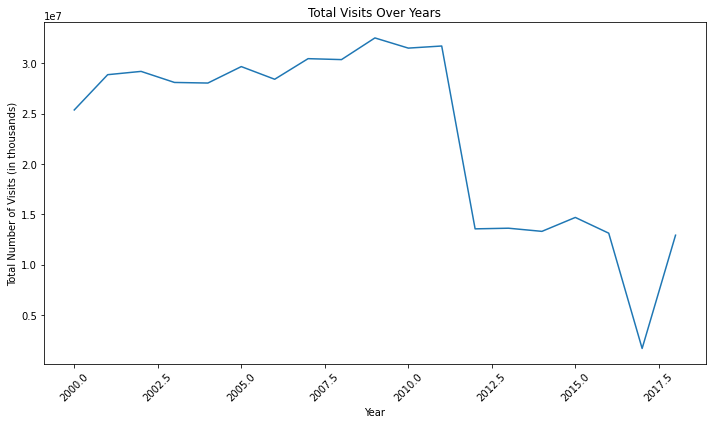

In [7]:
#Total Visits Over Years
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='estimate', estimator='sum', ci=None)
plt.title('Total Visits Over Years')
plt.ylabel('Total Number of Visits (in thousands)')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

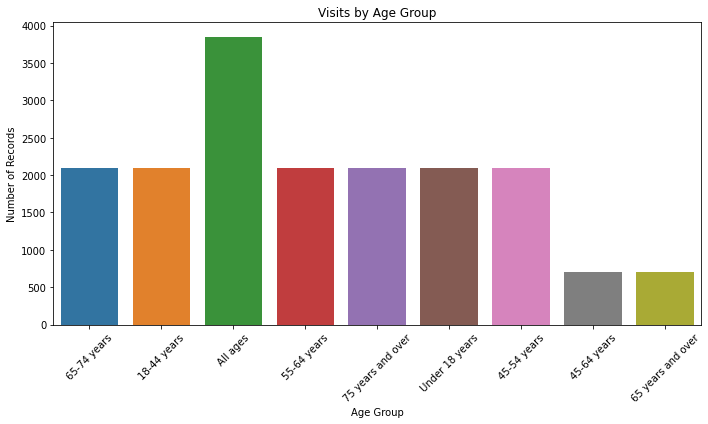

In [8]:
#Visits by Age Group
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age')
plt.title('Visits by Age Group')
plt.ylabel('Number of Records')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

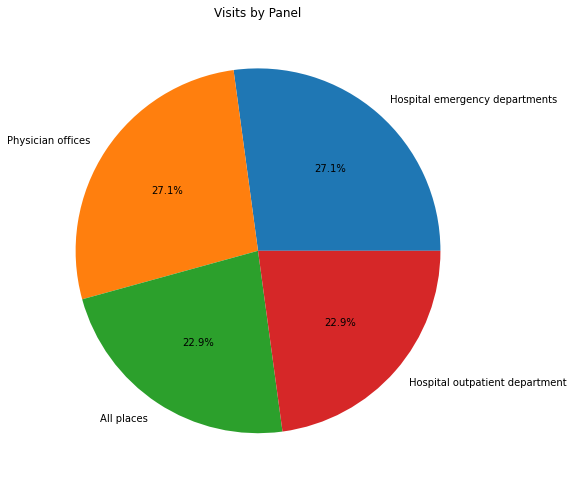

In [9]:
#Visits by Panel
plt.figure(figsize=(8, 8))
df['panel'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Visits by Panel')
plt.ylabel('')
plt.tight_layout()
plt.show()

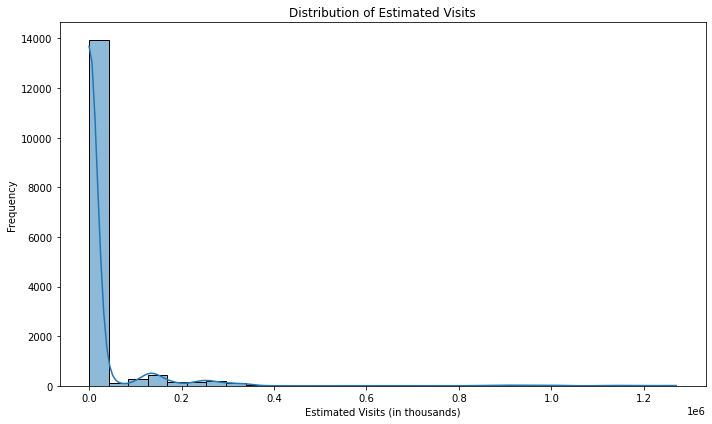

In [10]:
# Estimate Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='estimate', bins=30, kde=True)
plt.title('Distribution of Estimated Visits')
plt.xlabel('Estimated Visits (in thousands)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

C:\Users\s43ag\AppData\Local\Temp\ipykernel_14776\2063660924.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=race_data, x='year', y='estimate', hue='stub_label', estimator='sum', ci=None)


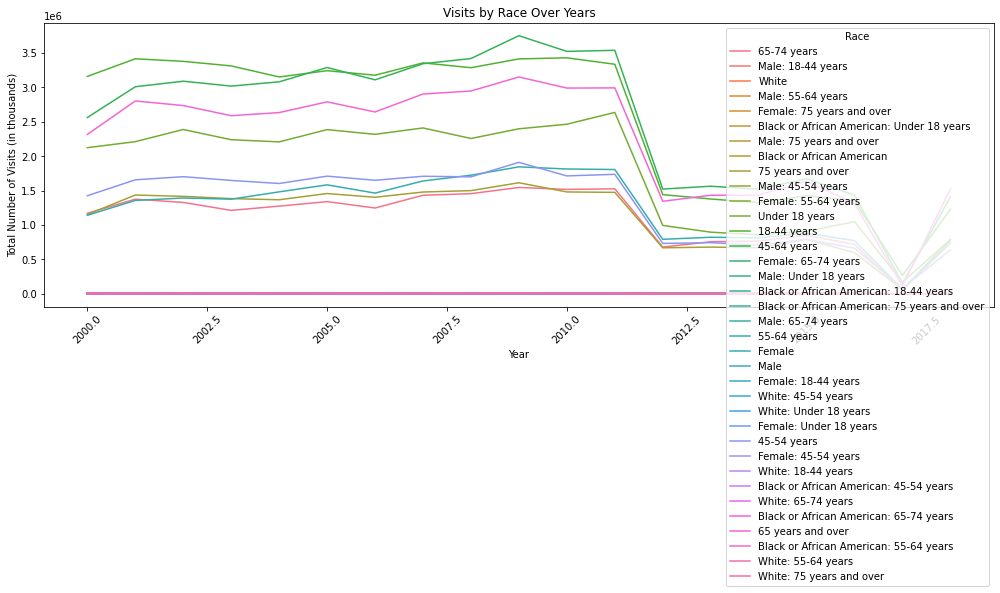

In [11]:
# Visits by Race Over Years
race_data = df[df['stub_label'] != 'All persons']  # Assuming 'All persons' is the aggregate category

plt.figure(figsize=(14, 7))
sns.lineplot(data=race_data, x='year', y='estimate', hue='stub_label', estimator='sum', ci=None)
plt.title('Visits by Race Over Years')
plt.ylabel('Total Number of Visits (in thousands)')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.legend(title='Race')
plt.tight_layout()
plt.show()


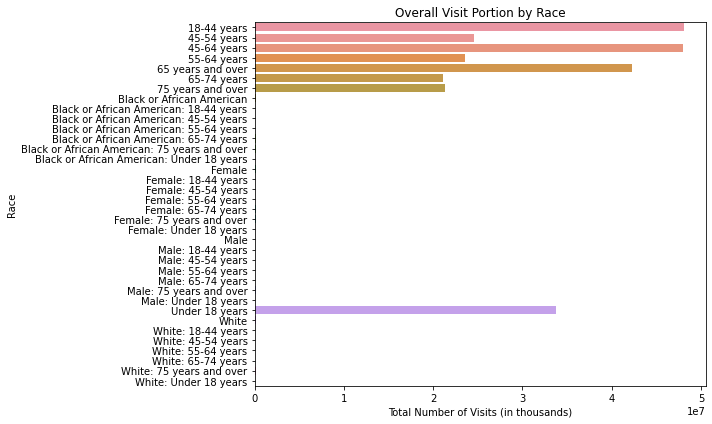

In [12]:
# Overall Visit Portion by Race
race_visit_sum = race_data.groupby('stub_label')['estimate'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=race_visit_sum, x='estimate', y='stub_label')
plt.title('Overall Visit Portion by Race')
plt.xlabel('Total Number of Visits (in thousands)')
plt.ylabel('Race')
plt.tight_layout()
plt.show()

<Figure size 1008x720 with 0 Axes>

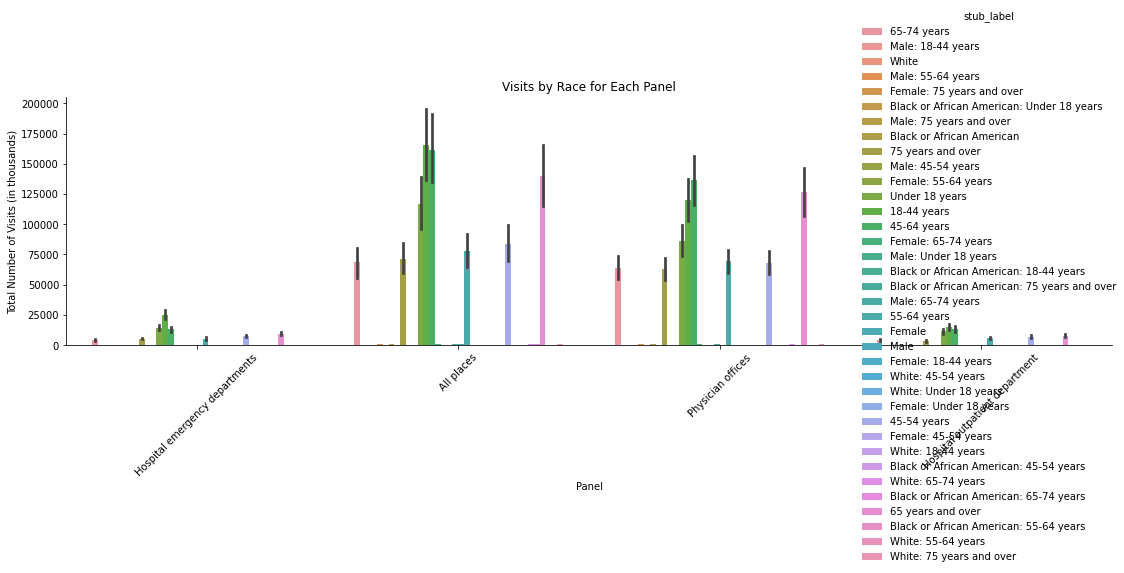

In [13]:
# Visits by Race for Each Panel (Sub Department)
plt.figure(figsize=(14, 10))
sns.catplot(data=race_data, x='panel', y='estimate', hue='stub_label', kind='bar', height=6, aspect=2)
plt.title('Visits by Race for Each Panel')
plt.ylabel('Total Number of Visits (in thousands)')
plt.xlabel('Panel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\s43ag\AppData\Local\Temp\ipykernel_14776\601930324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_data['estimate'] = pd.to_numeric(race_data['estimate'], errors='coerce')
C:\Users\s43ag\AppData\Local\Temp\ipykernel_14776\601930324.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_data.dropna(subset=['estimate'], inplace=True)
C:\Users\s43ag\AppData\Local\Temp\ipykernel_14776\601930324.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=race_data, x='age', y='estimate', hue

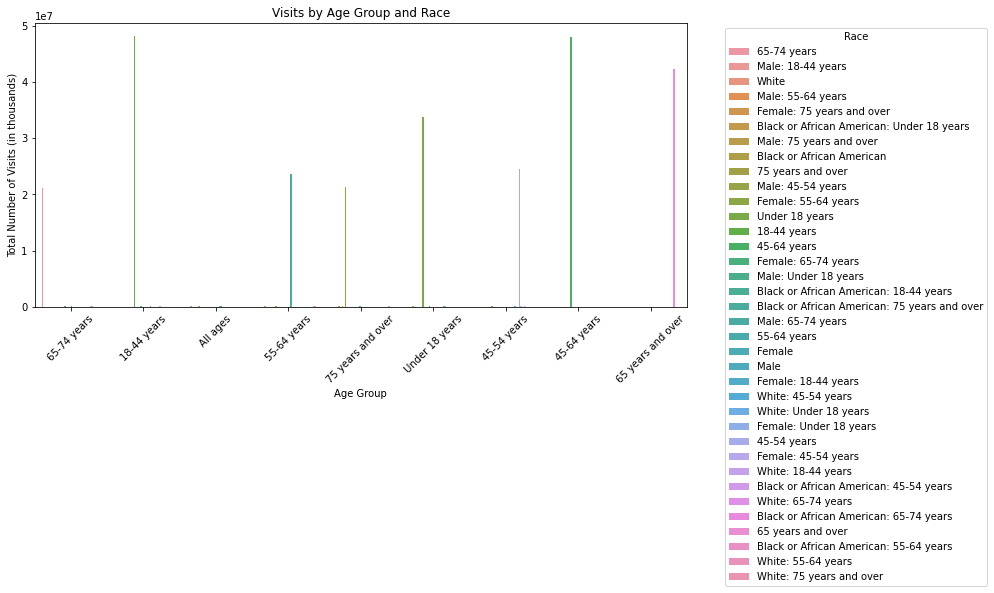

In [15]:
import numpy as np
# Visits by Age Group and Race
race_data['estimate'] = pd.to_numeric(race_data['estimate'], errors='coerce')

# Dropping NaN values from 'estimate'
race_data.dropna(subset=['estimate'], inplace=True)

plt.figure(figsize=(14, 7))
sns.barplot(data=race_data, x='age', y='estimate', hue='stub_label', estimator=np.sum, ci=None)
plt.title('Visits by Age Group and Race')
plt.ylabel('Total Number of Visits (in thousands)')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()